# Predicting Temperature and Humidity Using a Basic Neural Network

The temperature and humidy data look quite different from each other. 

In this exercise you can experiment by adjusting the frequency, amount of training data, and feature to learn which parameters give you the best scoring models.

In [4]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

from scripts.data import deutsches_wetterdienst
from scripts.grid import grid_search

## The Data

Deutsches Wetterdienst data set contains temperature and humidity readings in Braunschweig Germany  during the years Jan 1951- Dec 2017. 

You use part of the data if you like, just change the 'start' and 'end' parameters for the function deutsches_wetterdienst().

The temperature and humidy data look quite different from eaach other.

In [5]:
df = deutsches_wetterdienst('/Users/stewarta/Documents/DATA/htsensor/produkt_tu_stunde_19510101_20171231_00662.txt', start=2010, end=2016)
df.head()

,Temp,Humi
datetime,,
2010-01-01 00:00:00,-1.8,89.0
2010-01-01 01:00:00,-1.8,88.0
2010-01-01 02:00:00,-1.8,89.0
2010-01-01 03:00:00,-1.8,88.0
2010-01-01 04:00:00,-2.1,91.0


## Experiment with the Model Parameters

### Change the Frequency

Here are a few frequency values that you can experiment with:

* YearEnd: 'A' calendar year end
* QuarterEnd: 'Q' calendar quarter end
* MonthEnd: 'M' calendar month end
* Week: 'W' one week, optionally anchored on a day of the week
* Day: 'D' one absolute day
* Hour: 'H' one hour

Learn more about datetime offsets in the pandas documentation:

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html?highlight=datetime


### Change the Feature

You can choose from Temperature (Temp) or Humidity (Humi). 

Experiment with the parameters, and discover which ones give you the best performing Neural Network models.

In [6]:
# change the frequency
timestep = 'M'

# change the feature
feature = 'Humi'
df = df.resample(timestep).mean().ffill()
df.head()

,Temp,Humi
datetime,,
2010-01-31,-3.879973,86.928763
2010-02-28,-0.284673,82.645833
2010-03-31,4.991398,75.493280
2010-04-30,9.473333,64.016667
2010-05-31,10.425134,79.571237


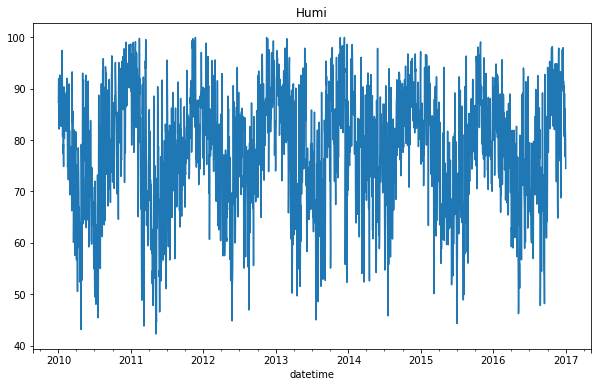

In [39]:
plt.figure(figsize=(10, 6))
plt.title(feature)
df[feature].plot();

## Training Data

Select the amount of training data you want to use by adjusting the "split_date".

The data before the split_date will be used to train and the data after the split_date will be used to for predicting the model performance.

In [7]:
split_date = pd.Timestamp('2016-01-01')

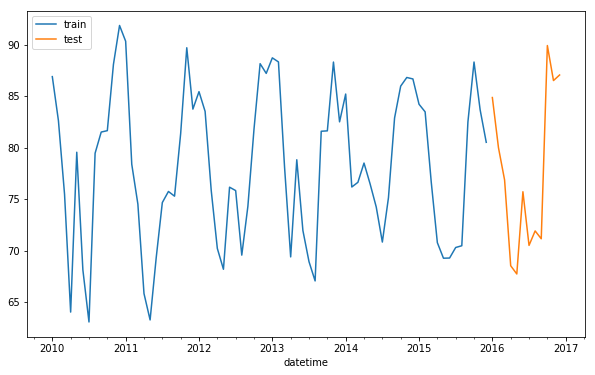

In [8]:
s =  df[feature]
train = s.loc[:split_date]
test = s.loc[split_date:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [9]:
# scale train and test data to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
train_sc = scaler.fit_transform(train.values.reshape(-1,1))
test_sc = scaler.transform(test.values.reshape(-1,1))

In [10]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

## Dense Neural Network

In [11]:
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
71/71 [==============================] - 0s 4ms/step - loss: 0.2083
Epoch 2/100
71/71 [==============================] - 0s 1ms/step - loss: 0.1751
Epoch 3/100
71/71 [==============================] - 0s 1ms/step - loss: 0.1582
Epoch 4/100
71/71 [==============================] - 0s 1ms/step - loss: 0.1500
Epoch 5/100
71/71 [==============================] - 0s 1ms/step - loss: 0.1464
Epoch 6/100
71/71 [==============================] - 0s 1ms/step - loss: 0.1449
Epoch 7/100
71/71 [==============================] - 0s 1ms/step - loss: 0.1439
Epoch 8/100
71/71 [==============================] - 0s 1ms/step - loss: 0.1431
Epoch 9/100
71/71 [==============================] - 0s 1ms/step - loss: 0.1425
Epoch 10/100
71/71 [==============================] - 0s 1ms/step - loss: 0.1419
Epoch 11/100
71/71 [==============================] - 0s 1ms/step - loss: 0.1414
Epoch 12/100
71/71 [==============================] - 0s 2ms/step - loss: 0.1410
Epoch 13/100
71/71 [=================

## Performance on Train and Test Sets

Evaluate the performance of the model using R2. The best possible value for R2 is 1.0.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

In [12]:
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

The R2 score on the Train set is:	0.485
The R2 score on the Test set is:	0.357


In [13]:
nn_test_mse = nn_model.evaluate(X_test, y_test, batch_size=1)
print('NN: %f'%nn_test_mse)

11/11 [==============================] - 0s 4ms/step
NN: 0.177348


In [14]:
nn_y_pred_test = nn_model.predict(X_test)

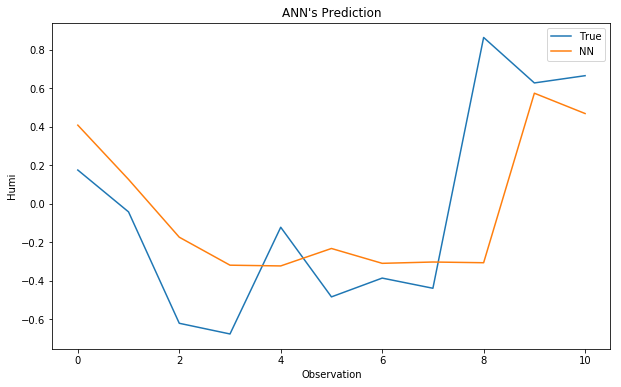

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_nn, label='NN')
plt.title("ANN's Prediction")
plt.xlabel('Observation')
plt.ylabel(feature)
plt.legend()
plt.show();